In [1]:
!pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import torch
# ! pip install sentence_transformers
# from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import gensim
import random
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import confusion_matrix
import seaborn as sn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay
from collections import Counter
import matplotlib.pyplot as plt

# Load the data

In [3]:
data = pd.read_csv("/content/data_processed.csv")
data

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,as a woman you shouldnt complain about cleani...
1,1,3,0,3,0,1,boy dats coldtyga dwn bad for cuffin dat hoe ...
2,2,3,0,3,0,1,dawg you ever fuck a bitch and she start to c...
3,3,3,0,2,1,1,she look like a tranny
4,4,6,0,6,0,1,the shit you hear about me might be true or i...
...,...,...,...,...,...,...,...
24768,25291,3,0,2,1,1,yous a muthafin lie right his tl is trash now ...
24769,25292,3,0,1,2,2,youve gone and broke the wrong heart baby and ...
24770,25294,3,0,3,0,1,young buck wanna eat dat nigguh like i aint fu...
24771,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [4]:
# model = SentenceTransformer('all-MiniLM-L6-v2')
sentences = data["tweet"]
# sentence_embeddings = model.encode(sentences)
words = [list(s.lower().split()) for s in sentences]

In [5]:
w2v = Word2Vec(sentences=words, size=384, window=5, min_count=1, workers=4)

# import gensim.downloader as api
# corpus = api.load('text8')  # download the corpus and return it opened as an iterable
# w2v = Word2Vec(corpus)
# w2v.train(sentences=words)

sentence_embeddings = [torch.as_tensor([w2v.wv[word] for word in list(s.lower().split())]) for s in sentences]

<ipython-input-5-2433b6dc6a7e>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  sentence_embeddings = [torch.as_tensor([w2v.wv[word] for word in list(s.lower().split())]) for s in sentences]


In [6]:
label = [np.array([data["hate_speech"][i]/data["count"][i],data["offensive_language"][i]/data["count"][i],data["neither"][i]/data["count"][i]]) for i in range(len(data))]

assert len(label) == len(sentence_embeddings)

# Train-validation-test split
We did a 80:16:4 train-validation-test split on the dataset.Because our training dataset is not balanced, there are more "offensive language" than "hate speech" and "neither", we implemented a balanced train-validation-test split by normalizing the dataset and adding more weight to "hate speech" and "neither".

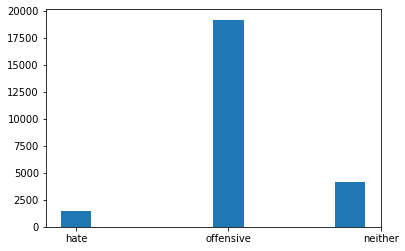

In [7]:
label = [np.array([data["hate_speech"][i]/data["count"][i],data["offensive_language"][i]/data["count"][i],data["neither"][i]/data["count"][i]]) for i in range(len(data))]
cla = [np.argmax(r) for r in label]
plt.hist(cla,align="left")
plt.xticks(np.arange(3),["hate","offensive","neither"])
plt.show()

In [8]:
def create_train_and_test_set_balanced(X, y, train_ratio=0.8):
    # TODO
    # process the list of (x,y) pairs and split them 80-20 into train and test set
    # train_x is a list of name embeddings each of size (num_characters_in_name, 1, n_letters), train_y is the corresponding list of language category index. Same for test_x and test_y

    X, X_rem, y, y_rem = X[0:int(train_ratio * len(X))], X[int(train_ratio * len(X)) + 1:-1], y[0:int(train_ratio * len(y))], y[int(train_ratio * len(y)) + 1:-1]
    labels = np.array([np.argmax(row) for row in y])
    counts = np.bincount(labels)
    label_weights = 1.0 / counts
    weights = label_weights[labels]
    index = list(WeightedRandomSampler(weights, len(weights)))
    X_train, y_train = [X[i] for i in index], [y[i] for i in index]
    # plt.hist(np.array([np.argmax(row) for row in y_train]))

    return X_train, X_rem, y_train, y_rem

In [9]:
X_train, X_rem, y_train, y_rem = create_train_and_test_set_balanced(sentence_embeddings,label)
X_valid, X_test, y_valid, y_test = create_train_and_test_set_balanced(X_rem,y_rem)

In [10]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class Tweet(Dataset):
    def __init__(self, X,y, transform=None):
        self.X = pad_sequence(X,batch_first=True)
        self.y = torch.as_tensor(np.array(y))
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        sentence = self.X[idx]
        label = self.y[idx]
        sample = {'sentence': sentence, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

# Define the model

In [11]:
hidden_size = 192
output_size = 3
batch_size = 50

valid_losses = []

In [12]:
train_data = Tweet(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0,drop_last=True)

valid_data = Tweet(X_valid, y_valid)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=0,drop_last=True)

test_data = Tweet(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=len(X_test), shuffle=True, num_workers=0,drop_last=True)

In [13]:
from sklearn.preprocessing import normalize
import torch.nn as nn
import torch
from torch.autograd import Variable


class lstm(nn.Module):
    def __init__(self, embedding_length=384,dropout=0.3):
        super(lstm, self).__init__()

        self.dropout = dropout
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.fc1 = nn.Linear(embedding_length, 256)
        self.lstm = nn.LSTM(embedding_length, self.hidden_size,batch_first=True,dropout=dropout, num_layers=1)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size//2)
        self.fc3 = nn.Linear(self.hidden_size//2, self.hidden_size//4)
        self.label = nn.Linear(self.hidden_size//4, self.output_size)
        self.relu = nn.ReLU()
        self.to("cuda")


    def forward(self,input):

        input = input.to("cuda")

        # input = self.fc1(input)
        # input = self.relu(input)

        h_0 = Variable(torch.zeros(1, len(input), self.hidden_size).cuda())
        c_0 = Variable(torch.zeros(1, len(input), self.hidden_size).cuda())


        output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))
        x = self.fc2(final_hidden_state[-1])
        x = self.fc3(x)

        return self.label(x)
    

    def fit(self, train_loader, epochs=100,lr=5e-5,interval=100):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        scheduler = ReduceLROnPlateau(optimizer, patience=20, threshold=5e-3)


        for epoch in range(epochs):
            running_loss = 0.0
            self.train()

            for i_batch, sample in enumerate(train_loader):
                sentences, labels = sample['sentence'].to("cuda"), sample['label'].to("cuda")

                outputs = self(sentences)
                loss = criterion(
                outputs.float(),
                labels.float()
            )

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                if i_batch % interval == 0 and i_batch > 0:
                    valid_loss = self.validate(valid_loader=valid_loader)
                    print(f"epoch:{epoch},batch: {i_batch}, train_loss: {running_loss/interval}, valid_loss: {valid_loss}")
                    running_loss = 0
            scheduler.step(self.validate(valid_loader))
            valid_losses.append([epoch,self.validate(valid_loader)])

    def validate(self, valid_loader):
        running_loss = 0
        val_count = 0
        # self.eval()
        criterion = torch.nn.CrossEntropyLoss()

        for i_batch, sample in enumerate(valid_loader):
            sentences, labels = sample['sentence'].to("cuda"), sample['label'].to("cuda")

            outputs = self(sentences)
            loss = criterion(
                outputs.float(),
                labels.float()
            )

            running_loss += loss.item()
            val_count += 1

        avg_loss = running_loss / val_count
        return avg_loss

    def accuracy(self,test_loader):
        self.eval()
        plt.figure(figsize=(10, 10))
        for i_batch, sample in enumerate(test_loader):
            sentences, labels = sample['sentence'], sample['label']
            labels = np.array([np.argmax(row) for row in labels])
    
            outputs = self(sentences)
            pred = np.array([np.argmax(outputs[i].cpu().detach().numpy()) for i in range(len(outputs))])
            assert len(pred) == len(labels)
            cm = pd.DataFrame(confusion_matrix(labels,pred,normalize="true"),index=["true hate speech","offensive language", "true neither"],columns=["predicted hate speech","predicted offensive language", "predicted neither"])
            
            sn.heatmap(data=cm,annot=True,xticklabels=True,yticklabels=True)
            plt.savefig("cm.pdf")
            plt.show()

            return np.sum(labels == pred) / len(pred)


    def predict(self,sentence):
        vec = torch.as_tensor([w2v.wv[word] for word in list(sentence.lower().split())])
        vec = vec.unsqueeze(0)
        index =  np.argmax(self(vec).cpu().detach().numpy()) 

        label_to_senti = {0:"hate speech",1:"offensive language",2:"neither"}
        # label_to_senti = {0:"offensive",1:"normal"}
        return label_to_senti[index]

    def metrics(self,test_loader):
        self.eval()
        plt.figure(figsize=(10, 10))
        for i_batch, sample in enumerate(test_loader):
            sentences, labels = sample['sentence'], sample['label']
            labels = np.array([np.argmax(row) for row in labels])
    
            outputs = self(sentences)
            pred = np.array([np.argmax(outputs[i].cpu().detach().numpy()) for i in range(len(outputs))])
            assert len(pred) == len(labels)
            accuracy = accuracy_score(labels, pred)
            # precision = precision_score(labels, pred, pos_label=0)
            # recall = recall_score(labels, pred, pos_label=0)
            # f1 = f1_score(labels, pred, pos_label=0)
            RocCurveDisplay.from_predictions(labels, pred, name="LSTM")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.savefig("roc.pdf")
            plt.show()
            print(f"Accuracy={accuracy}\nPrecision={precision}\nRecall={recall}\nF1={f1}")

            

In [14]:
lstm_model = lstm()
valid_losses = []
lstm_model.fit(train_loader=train_loader)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


epoch:0,batch: 100, train_loss: 1.1046957182884216, valid_loss: 1.082172229320188
epoch:0,batch: 200, train_loss: 1.0790231788158418, valid_loss: 1.078259232677991
epoch:0,batch: 300, train_loss: 1.0818268370628357, valid_loss: 1.0779044341437425
epoch:1,batch: 100, train_loss: 1.0912450087070464, valid_loss: 1.0727110120314587
epoch:1,batch: 200, train_loss: 1.0590199077129363, valid_loss: 1.030018141752557
epoch:1,batch: 300, train_loss: 0.9965020710229874, valid_loss: 0.9753842602802228
epoch:2,batch: 100, train_loss: 0.9249543672800065, valid_loss: 0.9516631877875026
epoch:2,batch: 200, train_loss: 0.9094504445791245, valid_loss: 0.8862774741800525
epoch:2,batch: 300, train_loss: 0.8836499691009522, valid_loss: 0.8847285682642008
epoch:3,batch: 100, train_loss: 0.88405044734478, valid_loss: 0.8671871257733695
epoch:3,batch: 200, train_loss: 0.8738725823163986, valid_loss: 0.8632720618308345
epoch:3,batch: 300, train_loss: 0.8675956189632416, valid_loss: 0.8552417732492278
epoch:4,b

Text(0, 0.5, 'valid loss')

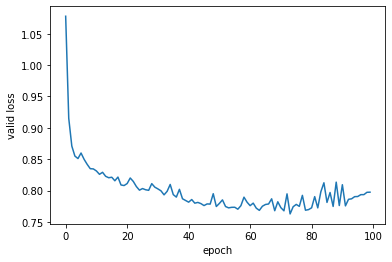

In [15]:
import matplotlib.pyplot as plt
plt.plot(np.array(valid_losses)[:,0],np.array(valid_losses)[:,1])
plt.xlabel("epoch")
plt.ylabel("valid loss")

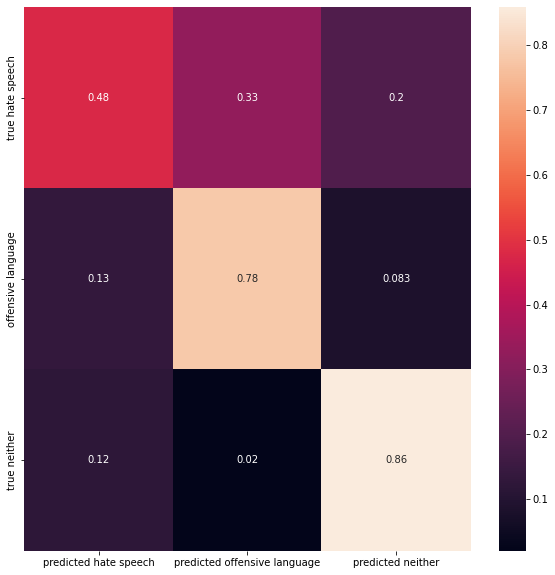

0.7795753286147624

In [16]:
lstm_model.accuracy(test_loader)

# Generate a list of improper words based on model prediction
We put the input tweets into the model and get a predicted label, then we do a binary classification based on the label (hate/offensive v.s. neither). Then we get a list of the most frequent words for each class, and remove those words that appear in both lists (these words are supposed to be common words in English, such as 'I', 'you', etc.). Then we take the remaining frequent "bad words" list as the list of the improper words.

In [17]:
def freq_bad_words():
    good_sentences = []
    bad_sentences = []

    sentences = data["tweet"]
    for s in sentences:
        lab = lstm_model.predict(s)
        if lab == "hate speech" or lab == "offensive language":
            bad_sentences.append(s)
        else:
            good_sentences.append(s)

    good_sentences = [list(s.lower().split()) for s in good_sentences]
    bad_sentences = [list(s.lower().split()) for s in bad_sentences]

    good_words = [item for sublist in good_sentences for item in sublist]
    bad_words = [item for sublist in bad_sentences for item in sublist]
    good_freq = [pair[0] for pair in Counter(good_words).most_common(200)]

    bad_words_clean = [w for w in bad_words if w not in good_freq]

    return [pair[0] for pair in Counter(bad_words_clean).most_common(10)]
freq_bad_words()

['bitch',
 'bitches',
 'hoes',
 'pussy',
 'hoe',
 'ass',
 'fuck',
 'shit',
 'nigga',
 'aint']